In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import empyrical
%matplotlib inline

In [3]:
assets_fname = u'../data/资产.xlsx'

In [4]:
names = [u'翁兆宇', u'张炀', u'曹越奇', u'潘弘林']

In [5]:
df = pd.read_excel(assets_fname, index_col=0, sheetname='Sheet1')

In [8]:
df.head()

,000906.SH,065.CS,SPGSCITR.SPI
2016-11-01,3910.6774,176.3682,2245.07
2016-11-02,3880.2052,176.3739,2209.59
2016-11-03,3911.1497,176.4394,2193.34
2016-11-04,3898.4476,176.4484,2173.50
2016-11-07,3901.5426,176.4149,2190.08


In [9]:
ret_df = df.pct_change()

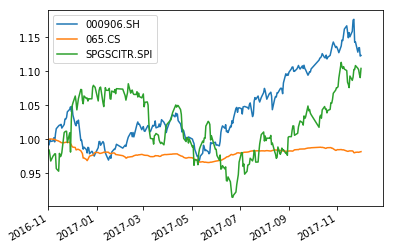

In [10]:
(1+ret_df).cumprod().plot()

In [11]:
est = pd.read_excel(assets_fname, index_col=0, sheetname='Sheet2')

In [12]:
est = est / 100

In [13]:
est['avg'] = est.mean(axis=1)

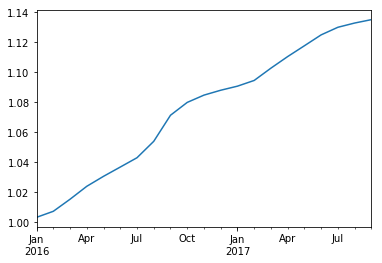

In [14]:
(1+est['avg']).cumprod().plot()

# 计算波动率

In [15]:
vol_df = ret_df.rolling(window=242).apply(lambda x: empyrical.annual_volatility(x, period='daily'))

In [16]:
vol_df.dropna().tail()

,000906.SH,065.CS,SPGSCITR.SPI
2017-11-27,0.105120,0.014751,0.142055
2017-11-28,0.105021,0.014497,0.140632
2017-11-29,0.104288,0.014484,0.140726
2017-11-30,0.103966,0.014481,0.140453
2017-12-01,0.103941,0.014023,0.140766


In [17]:
est_vol = est['avg'].rolling(window=12).apply(lambda x: empyrical.annual_volatility(x, period='monthly'))

In [18]:
est_vol.tail()

2017-05-31    0.013221
2017-06-30    0.013198
2017-07-31    0.013385
2017-08-31    0.013303
2017-09-30    0.007508
Name: avg, dtype: float64

# 根据打分计算风险权重、资产权重

In [19]:
for name in names:
    print name
    fname = u'../data/%s-打分.xlsx'%(name)
    score = pd.read_excel(fname, index_col=0)
    current = vol_df[vol_df.index == score.index[-1]]
    current.loc[:, 'Real Estate'] = est_vol[-1]
    weight = score.iloc[-1].values / current
    weight = weight.div(weight.sum(axis=1), axis='index')
    fname = u'../data/%s-权重.xlsx'%(name)
    weight_df = pd.read_excel(fname)
    if weight_df.index[-1] == weight.index[-1]:
        continue
    print weight_df
    print weight
#     weight.columns = weight_df.columns
#     weight_df = weight_df.append(weight)
#     weight_df.to_excel(fname)

翁兆宇
张炀
曹越奇


C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


潘弘林


# 计算每人收益率

In [20]:
fname = u'../data/%s-权重.xlsx'%(names[1])
weight_df = pd.read_excel(fname, index_col=0)

In [21]:
weight_df

,Equity,Bond,Commodity,Real Estate
2017-11-13,0.18417,0.576466,0.096663,0.142701


In [22]:
df = df[df.index >= weight_df.index[-1]]

In [23]:
ret_df = df.pct_change().dropna()

In [24]:
ret_df['real estate'] = 0.

In [25]:
ret_df.columns = weight_df.columns

In [26]:
ret_df

,Equity,Bond,Commodity,Real Estate
2017-11-14,-0.007375,-0.000545,-0.015572,0.0
2017-11-15,-0.007712,0.000043,-0.002848,0.0
2017-11-16,0.006473,0.000507,-0.004422,0.0
2017-11-17,-0.005211,0.000091,0.015801,0.0
2017-11-20,0.007047,-0.000003,-0.005836,0.0
2017-11-21,0.014089,-0.000620,0.004382,0.0
2017-11-22,0.001050,-0.002008,0.010297,0.0
2017-11-23,-0.028573,-0.000185,0.000000,0.0
2017-11-24,0.000472,0.000712,0.005223,0.0
2017-11-27,-0.013240,0.000243,-0.003621,0.0


In [27]:
daily_weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)

In [28]:
prev_weight = weight_df.iloc[-1]
daily_weight.iloc[0] = prev_weight
for date in ret_df.index[1:]:
    daily_weight.loc[date] = (1 + ret_df.loc[date]) * prev_weight
    prev_weight = daily_weight.loc[date]
daily_weight = daily_weight.div(daily_weight.sum(axis=1), axis='index')

In [29]:
weight_df

,Equity,Bond,Commodity,Real Estate
2017-11-13,0.18417,0.576466,0.096663,0.142701


In [30]:
daily_weight

,Equity,Bond,Commodity,Real Estate
2017-11-14,0.18417,0.576466,0.0966627,0.142701
2017-11-15,0.183056,0.577456,0.0965487,0.14294
2017-11-16,0.184047,0.577142,0.0960209,0.14279
2017-11-17,0.182976,0.576842,0.0974786,0.142703
2017-11-20,0.184133,0.576426,0.0968401,0.1426
2017-11-21,0.186232,0.57454,0.0970063,0.142222
2017-11-22,0.18642,0.573363,0.0980012,0.142216
2017-11-23,0.182083,0.576388,0.0985365,0.142993
2017-11-24,0.181985,0.576216,0.0989512,0.142849
2017-11-27,0.180048,0.577874,0.0988527,0.143225


In [31]:
dic = {}
for name in names:
    print name
    fname = u'../data/%s-权重.xlsx'%(name)
    weight_df = pd.read_excel(fname, index_col=0)
    df = df[df.index >= weight_df.index[-1]]
    ret_df = df.pct_change().dropna()
    ret_df['real estate'] = 0.
    ret_df.columns = weight_df.columns
    daily_weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
    prev_weight = weight_df.iloc[-1]
    daily_weight.iloc[0] = prev_weight
    for date in ret_df.index[1:]:
        daily_weight.loc[date] = (1 + ret_df.loc[date]) * prev_weight
        prev_weight = daily_weight.loc[date]
    daily_weight = daily_weight.div(daily_weight.sum(axis=1), axis='index')
    daily_weight.to_excel(u'../data/%s-每日权重.xlsx'%(name))
    dic[name] = (daily_weight * ret_df).sum(axis=1)
return_df = pd.DataFrame(dic)

翁兆宇
张炀
曹越奇
潘弘林


# 综合打分

In [32]:
weight_dic = {}
for name in names:
    weight_dic[name] = pd.read_excel(u'../data/%s-每日权重.xlsx'%(name))

In [33]:
weight_weight = 2.5 * weight_dic[u'翁兆宇'] + \
                1.0 * weight_dic[u'张炀'] + \
                1.0 * weight_dic[u'曹越奇'] + \
                1.0 * weight_dic[u'潘弘林']

In [34]:
weight_weight = weight_weight / 5.5

In [35]:
return_df[u'综合'] = (ret_df * weight_weight).sum(axis=1)

In [36]:
return_df

,张炀,曹越奇,潘弘林,翁兆宇,综合
2017-11-14,-0.003177,-0.001222,-0.002410,-1.900967e-03,-0.002102
2017-11-15,-0.001662,-0.000545,-0.001176,-7.014601e-04,-0.000934
2017-11-16,0.001059,0.000401,0.000875,2.707791e-04,0.000548
2017-11-17,0.000639,0.000327,0.000491,9.416499e-04,0.000693
2017-11-20,0.000731,0.000196,0.000515,-5.978524e-07,0.000262
2017-11-21,0.002693,0.000786,0.001774,1.031283e-03,0.001424
2017-11-22,0.000054,-0.000270,-0.000441,1.182940e-04,-0.000066
2017-11-23,-0.005309,-0.001737,-0.003829,-1.897967e-03,-0.002840
2017-11-24,0.001013,0.000488,0.000900,7.188910e-04,0.000763
2017-11-27,-0.002601,-0.000815,-0.001797,-1.031126e-03,-0.001417


In [37]:
old_df = pd.read_excel(u'../data/收益率.xlsx')

In [38]:
old_df

,张炀,曹越奇,潘弘林,翁兆宇,综合
2017-11-14,-0.003177,-0.001222,-0.002410,-1.900967e-03,-0.002102
2017-11-15,-0.001662,-0.000545,-0.001176,-7.014601e-04,-0.000934
2017-11-16,0.001059,0.000401,0.000875,2.707791e-04,0.000548
2017-11-17,0.000639,0.000327,0.000491,9.416499e-04,0.000693
2017-11-20,0.000731,0.000196,0.000515,-5.978524e-07,0.000262
2017-11-21,0.002693,0.000786,0.001774,1.031283e-03,0.001424
2017-11-22,0.000054,-0.000270,-0.000441,1.182940e-04,-0.000066
2017-11-23,-0.005309,-0.001737,-0.003829,-1.897967e-03,-0.002840
2017-11-24,0.001013,0.000488,0.000900,7.188910e-04,0.000763


In [39]:
old_df = old_df[old_df.index < return_df.index[0]]

In [40]:
old_df.append(return_df)

,张炀,曹越奇,潘弘林,翁兆宇,综合
2017-11-14,-0.003177,-0.001222,-0.002410,-1.900967e-03,-0.002102
2017-11-15,-0.001662,-0.000545,-0.001176,-7.014601e-04,-0.000934
2017-11-16,0.001059,0.000401,0.000875,2.707791e-04,0.000548
2017-11-17,0.000639,0.000327,0.000491,9.416499e-04,0.000693
2017-11-20,0.000731,0.000196,0.000515,-5.978524e-07,0.000262
2017-11-21,0.002693,0.000786,0.001774,1.031283e-03,0.001424
2017-11-22,0.000054,-0.000270,-0.000441,1.182940e-04,-0.000066
2017-11-23,-0.005309,-0.001737,-0.003829,-1.897967e-03,-0.002840
2017-11-24,0.001013,0.000488,0.000900,7.188910e-04,0.000763
2017-11-27,-0.002601,-0.000815,-0.001797,-1.031126e-03,-0.001417


In [41]:
old_df.append(return_df).to_excel(u'../data/收益率.xlsx')

In [42]:
return_df = pd.read_excel(u'../data/收益率.xlsx')

In [43]:
(1+return_df).cumprod().to_excel(u'../data/净值.xlsx')